/home/ubuntu/miniconda3/envs/regllava/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-13 07:13:00,882] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Added to sys.path: /home/ubuntu/Projects/regllava
✔ CustomVisionTransformer imported.
▶ Loading model...
Loading LLaVA from base model...


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 15196.75it/s]


/home/ubuntu/Projects/regllava/INFERclipregXGATED 에서 INFERclipregXGATED 모듈을 성공적으로 임포트했습니다.


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at lmsys/vicuna-7b-v1.5 and are newly initialized: ['model.mm_projector.0.bias', 'model.mm_projector.0.weight', 'model.mm_projector.2.bias', 'model.mm_projector.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CLIPVisionTower 로드 시 사용할 target_dtype: torch.float32 (fp16: False, bf16: False)
로딩 시작: 사용자 정의 Reg-Gated CLIP 모델 (./models/ViT-L-14-REG-GATED-balanced-ckpt12.safetensors)
Checking model parameters... You should see [261, _ ]. If you see [257, _ ], something is wrong.
vision_width, vision_layers, patch_size, grid_size:, new_pos_embed: 1024, 24, 14, 16, 261
사용자 정의 Reg‑Gated CLIP 모델 로드 완료. 입력 해상도: 224, 패치 크기: 14
✅ Model loaded.
✅  mm_projector weights loaded: 4 tensors
Debug: CustomVisionTransformer.__init__ signature: (self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int, num_registers: int = 4)
None
✅ Custom vision encoder loaded: 344 tensors
   → missing keys: ['proj']
✅ Custom vision encoder loaded: ./models/ViT-L-14-REG-GATED-balanced-ckpt12.safetensors
Conversation mode → llava_v1
Loaded image: (1300, 954)
Debug: Vision tower type: <class 'llava.model.multimodal_encoder.clip_encoder.CLIPVisionTower'>
Debug: inner vision_tower type: <class

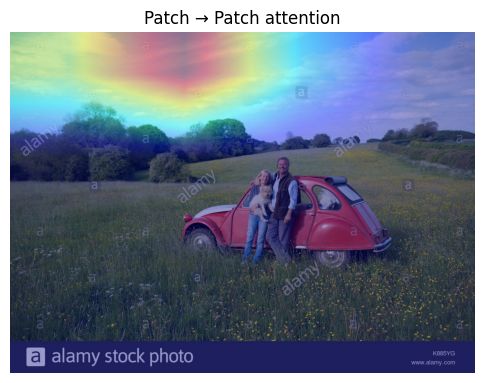


[USER] Describe the image in detail.
[ASSISTANT] 
The image is a photograph of a forest path in the mountains. The path is winding and narrow, with tall trees on either side. The trees are mostly conifers, with some deciduous trees mixed in. The path is covered in a thick layer of pine needles, which create a soft, cushioned surface to walk on. The air is fresh and crisp, with the scent of pine in the air. The sky is a bright blue, with a few fluffy white clouds. The sun is shining, casting dappled light through the trees. The overall feeling of the image is one of peacefulness and serenity, with the sound of a babbling brook in the distance.


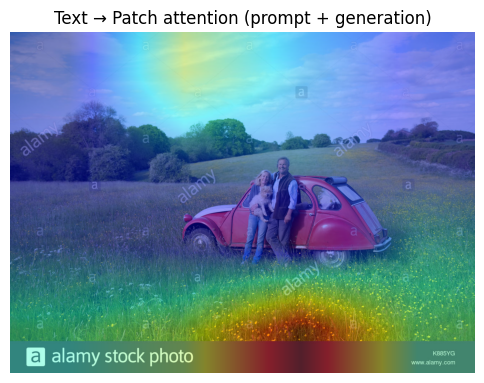

In [ ]:
# %% [markdown]
# # LLaVA Custom Vision Encoder / Projector Inference Notebook
# 사용자 정의 Reg‑Gated ViT‑L/14 + 맞춤 Projector 를 Vicuna‑7B 기반 LLaVA 모델에 적용하여
# – 모델 로드, 이미지 추론, Cross‑Attention 시각화 – 를 수행합니다.

# %% ---------------------------------------------------------------------------
# 0. 환경 설정 & 공통 라이브러리
# ---------------------------------------------------------------------------
import os, sys, warnings, shutil
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.4"
os.environ["LD_LIBRARY_PATH"] = (
    "/usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.4/lib64:"
    + os.environ.get("LD_LIBRARY_PATH", "")
)

import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, cv2, math
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

from transformers import (
    AutoConfig, AutoTokenizer, BitsAndBytesConfig, TextStreamer
)
from llava.constants import (
    IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images, tokenizer_image_token, get_model_name_from_path
)
from llava.model.builder import load_pretrained_model

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
torch.backends.cuda.enable_flash_sdp(False)

# LLaVA 프로젝트 루트가 sys.path 에 없으면 추가
nb_root = os.getcwd()
if nb_root not in sys.path:
    sys.path.insert(0, nb_root)
    print("Added to sys.path:", nb_root)

# 사용자 정의 CLIP
from INFERclipregXGATED.model import VisionTransformer as CustomVisionTransformer
print("✔ CustomVisionTransformer imported.")
# %% ---------------------------------------------------------------------------
# 1. 사용자 설정
# ---------------------------------------------------------------------------
MODEL_PATH_LLAVA_CONFIG_AND_PROJECTOR = "./llava-v1.5-7b-local"
MODEL_BASE_LLM = "lmsys/vicuna-7b-v1.5"

CUSTOM_VISION_ENCODER_WEIGHTS_PATH = "./models/ViT-L-14-REG-GATED-balanced-ckpt12.safetensors"
CUSTOM_PROJECTOR_FILENAME = "mm_projector_1epoch.bin"

IMAGE_FILE_TO_PROCESS = "data/car.jpg"
USER_PROMPT = "Describe the where the main object is located in the image."

DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
LOAD_8BIT = False
LOAD_4BIT = False

MAX_NEW_TOKENS = 256
TEMPERATURE = 0.2
CONV_MODE = None          # "vicuna_v1" 등으로 지정 가능, None 이면 자동 추론

VISION_ENCODER_CONFIG = dict(
    image_resolution=224, patch_size=14,
    width=1024, layers=24, heads=16,
    output_dim=1024, num_registers=4
)
mm_vision_select_layer_val = -2
mm_projector_type_val      = "mlp2x_gelu"
# %% ---------------------------------------------------------------------------
# 2. 유틸리티 함수
# ---------------------------------------------------------------------------
def load_image(path_or_url: str) -> Image.Image:
    if path_or_url.startswith(("http://", "https://")):
        resp = requests.get(path_or_url); resp.raise_for_status()
        return Image.open(BytesIO(resp.content)).convert("RGB")
    if not os.path.exists(path_or_url):
        raise FileNotFoundError(path_or_url)
    return Image.open(path_or_url).convert("RGB")

def overlay_heatmap(hm: np.ndarray, base: Image.Image) -> np.ndarray:
    bgr = cv2.cvtColor(np.array(base), cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]
    hm = cv2.resize(hm.astype(np.float32), (w, h), interpolation=cv2.INTER_LINEAR)
    hm = (hm - hm.min()) / (hm.ptp() + 1e-8)
    hm_cm = cv2.applyColorMap((hm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    mix  = cv2.addWeighted(bgr, 0.6, hm_cm, 0.4, 0)
    return cv2.cvtColor(mix, cv2.COLOR_BGR2RGB)

def infer_conv_mode(model_name: str) -> str:
    name = model_name.lower()
    if "llama-2"   in name: return "llava_llama_2"
    if "mistral"   in name: return "mistral_instruct"
    if "v1.6-34b"  in name: return "chatml_direct"
    if "v1"        in name: return "llava_v1"
    if "mpt"       in name: return "mpt"
    return "llava_v0"
# %% ---------------------------------------------------------------------------
# 3. 모델 로드 (builder.py 수정 버전 사용)
# ---------------------------------------------------------------------------
print("▶ Loading model...")
disable_torch_init()

model_arch_name = get_model_name_from_path(MODEL_PATH_LLAVA_CONFIG_AND_PROJECTOR)
tokenizer, model, image_processor, _ctx_len = load_pretrained_model(
    MODEL_PATH_LLAVA_CONFIG_AND_PROJECTOR,
    model_base=MODEL_BASE_LLM,
    model_name=model_arch_name,
    load_8bit=LOAD_8BIT, load_4bit=LOAD_4BIT,
    device=DEVICE,
    device_map={ "": DEVICE },          # ← 모든 서브모듈을 ***단일 GPU*** 로 고정
    attn_implementation="eager"
)
print("✅ Model loaded.")

# → MAIN_DEV 정의 (모델 파라미터가 올라간 디바이스)
MAIN_DEV = next(model.parameters()).device


# ─── Method B: pad_token을 eos와 구분하도록 special_tokens 추가 ─────────────────
if tokenizer.pad_token_id == tokenizer.eos_token_id:
    tokenizer.add_special_tokens({'pad_token': '<pad>'})
    model.resize_token_embeddings(len(tokenizer))
# ---------------------------------------------------------------------------
# 3‑1. 사용할 **단일 GPU** 확정 & 모듈·입력 tensor 통일
# ---------------------------------------------------------------------------
#  • Accelerate `device_map="auto"` 로드 시 모듈이 GPU‑0, GPU‑1 에 분산될 수 있음
#  • Vision Tower 출력 → mm_projector → LLM 으로 흐르므로
#    세 모듈·입력이 **한 GPU** 에 있어야 dtype/device 오류가 안 난다

MAIN_DEV = next(model.parameters()).device          # 보통 cuda:0

proj_path = os.path.join(MODEL_PATH_LLAVA_CONFIG_AND_PROJECTOR,
                         CUSTOM_PROJECTOR_FILENAME)
assert os.path.exists(proj_path), f"Projector file not found: {proj_path}"
raw_state = torch.load(proj_path, map_location="cpu")   # CPU 로 우선 읽기

def extract_mm_projector(sd):
    cleaned = {}
    for k, v in sd.items():
        if "mm_projector" not in k:
            continue                      # 다른 서브모듈은 무시
        k = k.split("mm_projector.", 1)[-1]   # → 0.weight …
        if k.startswith("module."):
            k = k[7:]                     # DataParallel prefix 제거
        cleaned[k] = v
    return cleaned

proj_state = extract_mm_projector(raw_state)
if not proj_state:
    raise ValueError("mm_projector keys가 체크포인트에 없습니다!")

# ② GPU · dtype 맞춰서 로드
model.get_model().mm_projector.to(device=MAIN_DEV, dtype=model.dtype)
model.get_model().mm_projector.load_state_dict(proj_state, strict=True)
print("✅  mm_projector weights loaded:", len(proj_state), "tensors")

# ① Vision Tower
vt = model.get_vision_tower()
# —— 1) Reg-Gated branch 강제 활성화 —— 
setattr(vt, "is_custom_reg_gated_clip", True)
# —— 2) config 에 우리가 원하는 레이어·프로젝터 세팅 심기 —— 
model.config.mm_vision_select_layer = mm_vision_select_layer_val
model.config.mm_projector_type      = mm_projector_type_val

# ==== 디버깅: CustomVisionTransformer 생성자 시그니처 확인 ====
import inspect
sig = inspect.signature(CustomVisionTransformer.__init__)
print("Debug: CustomVisionTransformer.__init__ signature:", sig)
print(CustomVisionTransformer.__init__.__doc__)
# ==== 디버깅 종료 ====

# —— 커스텀 Reg-Gated ViT-L/14 인코더로 교체 & 가중치 로드 ——
from safetensors.torch import load_file as load_safetensors
# VISION_ENCODER_CONFIG 키 이름을 생성자 시그니처(input_resolution, patch_size, width, layers, heads, output_dim, num_registers) 에 맞춰 매핑
custom_vt = CustomVisionTransformer(
    input_resolution = VISION_ENCODER_CONFIG['image_resolution'],
    patch_size       = VISION_ENCODER_CONFIG['patch_size'],
    width            = VISION_ENCODER_CONFIG['width'],
    layers           = VISION_ENCODER_CONFIG['layers'],
    heads            = VISION_ENCODER_CONFIG['heads'],
    output_dim       = VISION_ENCODER_CONFIG['output_dim'],
    num_registers    = VISION_ENCODER_CONFIG['num_registers'],
)

# ——— checkpoint 읽어서 모델에 맞게 필터링 후 로드 ———
state_v = load_safetensors(CUSTOM_VISION_ENCODER_WEIGHTS_PATH)
from collections import OrderedDict
filtered_state = OrderedDict()
# checkpoint key 에 'visual.' prefix 있으면 제거
for k, v in state_v.items():
    name = k[len("visual."):] if k.startswith("visual.") else k
    # 모델에 존재하고 모양이 정확히 같은 파라미터만 담기
    if name in custom_vt.state_dict() and custom_vt.state_dict()[name].shape == v.shape:
        filtered_state[name] = v
# strict=False 로 불일치 항목(크기/이름) 무시하고 로드
missing_keys, unexpected_keys = custom_vt.load_state_dict(filtered_state, strict=False)
print(f"✅ Custom vision encoder loaded: {len(filtered_state)} tensors")
if missing_keys:
    print("   → missing keys:", missing_keys)
if unexpected_keys:
    print("   → unexpected keys (ignored):", unexpected_keys)

custom_vt.to(device=MAIN_DEV, dtype=model.dtype)
# LLaVA wrapper 안의 vision_tower 속성에 덮어쓰기
vt.vision_tower = custom_vt
print("✅ Custom vision encoder loaded:", CUSTOM_VISION_ENCODER_WEIGHTS_PATH)

# 이후 기존 방식대로 single-GPU, dtype 통일
vt.to(device=MAIN_DEV, dtype=model.dtype)
if hasattr(vt, "vision_tower"):
    vt.vision_tower.to(device=MAIN_DEV, dtype=model.dtype)

# ② Projector
model.get_model().mm_projector.to(device=MAIN_DEV, dtype=model.dtype)

# ---------------------------------------------------------------------------

# conv 템플릿 선택
conv_key = CONV_MODE or infer_conv_mode(model_arch_name)
if conv_key not in conv_templates:
    raise ValueError(f"Unknown conversation mode '{conv_key}'")
conv = conv_templates[conv_key].copy()
roles = ("user", "assistant") if "mpt" in model_arch_name.lower() else conv.roles
print("Conversation mode →", conv_key)

# %% ---------------------------------------------------------------------------
# 4. 이미지 로드 & 전처리
# ---------------------------------------------------------------------------
pil_img = load_image(IMAGE_FILE_TO_PROCESS)
img_size = pil_img.size
print("Loaded image:", img_size)

img_tensor = process_images([pil_img], image_processor, model.config)
# LLaVA forward 는 list[Tensor] 를 요구 ⇒ 항상 list 로 맞춘다
if not isinstance(img_tensor, list):
    img_tensor = [img_tensor]
img_tensor = [t.to(MAIN_DEV, dtype=model.dtype) for t in img_tensor]

# ==== 디버깅 코드 추가 시작 ====
# Vision tower 타입 확인
print("Debug: Vision tower type:", type(model.get_vision_tower()))

# Projector 출력값 sum/mean/std 확인
with torch.no_grad():
    # VisionTower.forward는 Tensor[B, C, H, W]를 받습니다.
    # img_tensor가 list[Tensor]이면 하나의 배치로 합칩니다.
    if isinstance(img_tensor, list):
        # 만약 각 요소가 [C, H, W] 형태라면 stack, [1, C, H, W] 형태라면 cat
        t0 = img_tensor[0]
        if t0.dim() == 3:
            images_tensor = torch.stack(img_tensor, dim=0)
        else:
            images_tensor = torch.cat(img_tensor, dim=0)
    else:
        images_tensor = img_tensor


    # ——— 추가 디버깅 #1: 내부 vision_tower 모듈 확인 ———
    vt = model.get_vision_tower()
    if hasattr(vt, "vision_tower"):
        print("Debug: inner vision_tower type:", type(vt.vision_tower))
    else:
        print("Debug: vision_tower has no .vision_tower attr")

    # ——— 추가 디버깅 #2: config 값 확인 ———
    print("Debug: config.mm_vision_select_layer =", getattr(model.config, "mm_vision_select_layer", None))
    print("Debug: config.mm_projector_type      =", getattr(model.config, "mm_projector_type", None))

    # ——— 추가 디버깅 #3: 내부 CLIP forward 결과(shape) ———
    if hasattr(vt, "vision_tower"):
        raw = vt.vision_tower(images_tensor)   # HF CLIPVisionModel 출력
        # raw 가 BaseModelOutputWithPooling 또는 tuple 일 수 있음
        hs = raw.last_hidden_state if hasattr(raw, "last_hidden_state") else raw[0]
        print("Debug: inner raw hidden_state shape:", tuple(hs.shape))


    # ——— 추가 디버깅: 설정값 확인 ———
    print("Debug: config.mm_vision_select_layer =", model.config.mm_vision_select_layer)
    print("Debug: config.mm_projector_type      =", model.config.mm_projector_type)

    # ——— 추가 디버깅: 내부 CLIP 히든스테이트 확인 ———
    vt = model.get_vision_tower()
    if hasattr(vt, "vision_tower"):
        raw = vt.vision_tower(images_tensor)  # HF CLIP backbone 출력
        # BaseModelOutputWithPooling 일 때
        hs = raw.last_hidden_state if hasattr(raw, "last_hidden_state") else raw[0]
        print("Debug: raw hidden_states shape:", tuple(hs.shape))
    else:
        print("Debug: vision_tower has no .vision_tower attr!")


    # ——— 직접 custom ViT-L/14 Reg-Gated 을 호출해서 register 토큰 추출 ———
    vt_local = model.get_vision_tower()
    # vt_local.vision_tower 에 덮어쓴 CustomVisionTransformer 호출
    raw_feats = vt_local.vision_tower(images_tensor)
    # raw_feats 가 [num_registers, dim] 이면 batch 차원 추가
    if raw_feats.dim() == 2:
        vt_feats = raw_feats.unsqueeze(0)          # → [1, R, D]
    else:
        vt_feats = raw_feats                       # → [B, R, D]
    print("Debug (direct vt): vt_feats shape:", tuple(vt_feats.shape))


    # ==== 추가 디버깅: vt_feats 정보 출력 ====
    print("Debug: vt_feats shape (wrapper):", tuple(vt_feats.shape))
    flat = vt_feats.flatten()
    print("Debug: vt_feats sample values:", flat[:5].detach().cpu().numpy())
    # =======================================

    proj_out  = model.get_model().mm_projector(vt_feats.to(model.dtype))
print(
    f"Debug: Projector output |sum|={proj_out.abs().sum().item():.4f}, "
    f"mean={proj_out.mean().item():.4f}, std={proj_out.std().item():.4f}"
)
# ==== 디버깅 코드 추가 종료 ====

# --- dtype mismatch 방지: vision tower 자체를 LLM dtype(fp16)으로 맞춤 ---
vt = model.get_vision_tower()
# (LLaVA wrapper → 내부 CLIP 모듈 두 단계 모두 **GPU fp16** 으로)
vt.to(device=model.device, dtype=model.dtype)
if hasattr(vt, "vision_tower"):
    vt.vision_tower.to(device=model.device, dtype=model.dtype)

# projector 역시 같은 GPU / dtype 으로 확실히 이동
model.get_model().mm_projector.to(device=model.device, dtype=model.dtype)
# %% ---------------------------------------------------------------------------
# 5. 프롬프트 구성
# ---------------------------------------------------------------------------
if model.config.mm_use_im_start_end:
    prompt_user = f"{DEFAULT_IM_START_TOKEN}{DEFAULT_IMAGE_TOKEN}{DEFAULT_IM_END_TOKEN}\n{USER_PROMPT}"
else:
    prompt_user = f"{DEFAULT_IMAGE_TOKEN}\n{USER_PROMPT}"

conv.append_message(roles[0], prompt_user)
conv.append_message(roles[1], None)
full_prompt = conv.get_prompt()

print("--- Prompt to tokenizer ---")
print(full_prompt)

input_ids = tokenizer_image_token(
    full_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
).unsqueeze(0).to(model.device)

# --- 디버그 가드: <image> 토큰이 꼭 포함됐는지 확인 ---
assert (input_ids == IMAGE_TOKEN_INDEX).sum().item() > 0, \
       "IMAGE_TOKEN_INDEX (-200) 가 input_ids 에 없습니다. <image> 토큰 치환 실패!"

attention_mask = torch.ones_like(input_ids)

# %% ---------------------------------------------------------------------------
# 6. (옵션) Cross‑Attention Heatmaps
# ---------------------------------------------------------------------------
VISUALIZE = True
if VISUALIZE:
    # ----------------------------------------------------------------------
    # 6‑A.  Patch → Patch  (vision‑tower 직후) heat‑map
    # ----------------------------------------------------------------------
    with torch.no_grad():
        outs_vt = model(
            input_ids=input_ids,
            images=img_tensor,
            image_sizes=[img_size],
            output_attentions=True,
            return_dict=True,
        )
    attn_vt = outs_vt.attentions[-1].sum(dim=1)[0].cpu()       # (seq, seq)

    # 이미지 패치 구간 인덱스 계산 (generate 전에 미리 저장)
    img_tok_pos = (input_ids[0] == IMAGE_TOKEN_INDEX).nonzero(as_tuple=True)[0].item()
    patch_len   = attn_vt.size(1) - img_tok_pos                # 전체 패치 수
    patch_vec   = attn_vt[img_tok_pos + 1,                     # Q: 첫 패치
                          img_tok_pos : img_tok_pos + patch_len]

    L = patch_vec.shape[0]
    grid = math.ceil(math.sqrt(L))
    if grid * grid != L:
        patch_vec = F.interpolate(
            patch_vec.float()[None,None],
            size=grid * grid,
            mode="linear",
            align_corners=False
        )[0,0].to(patch_vec.dtype)
    patch_map = patch_vec.float().reshape(grid, grid)
    heatA = F.interpolate(
        patch_map[None,None],
        size=pil_img.size[::-1],
        mode="bilinear",
        align_corners=False
    )[0,0].cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.title("Patch → Patch attention")
    plt.imshow(overlay_heatmap(heatA, pil_img)); plt.axis("off"); plt.show()

# %% ---------------------------------------------------------------------------
# 7. 텍스트 생성
# ---------------------------------------------------------------------------
print(f"\n[{roles[0]}] {USER_PROMPT}")
print(f"[{roles[1]}] ", flush=True)

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
gen_kwargs = dict(
    inputs=input_ids,
    attention_mask=attention_mask,
    images=img_tensor,
    image_sizes=[img_size],
    do_sample=TEMPERATURE > 0,
    temperature=TEMPERATURE,
    max_new_tokens=MAX_NEW_TOKENS,
    streamer=streamer,
    use_cache=True,
    pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
    output_attentions=True,
    return_dict_in_generate=True
)

with torch.inference_mode():
    out_gen = model.generate(**gen_kwargs)

# ---------------------------------------------------------------------------
# 8. (옵션) 프롬프트 + 생성 토큰까지 포함한 Text → Patch heat‑map
# ---------------------------------------------------------------------------
if VISUALIZE:
    # out_gen.sequences 는 <image> 토큰이 빠져 있으므로,
    # 원본 input_ids 와 생성 토큰(gen_only)을 이어 붙여 완전한 시퀀스 복원
    gen_only   = out_gen.sequences[:, input_ids.size(1):]
    seqs_full  = torch.cat([input_ids, gen_only], dim=1)

    with torch.no_grad():
        outs_full = model(
            input_ids=seqs_full,
            images=img_tensor,
            image_sizes=[img_size],
            output_attentions=True,
            return_dict=True,
        )

    full_attn = outs_full.attentions[-1].sum(dim=1)[0].cpu()   # (seq, seq)

    # 프롬프트 / 생성 토큰 (텍스트 영역) ➜ 이미지 패치 구간
    text_start = img_tok_pos + patch_len
    text_end   = full_attn.size(1)
    txt2img_vec = full_attn[text_start:text_end,
                            img_tok_pos : img_tok_pos + patch_len].mean(dim=0)
    # ── 수정: NaN 방지 ───────────────────────────────────────────
    txt2img_vec = torch.nan_to_num(txt2img_vec, nan=0.0)
    # ───────────────────────────────────────────────────────────────

    L   = txt2img_vec.shape[0]
    grid = math.ceil(math.sqrt(L))
    if grid * grid != L:
        txt2img_vec = F.interpolate(
            txt2img_vec.float()[None,None],
            size=grid * grid,
            mode="linear",
            align_corners=False
        )[0,0].to(txt2img_vec.dtype)
    txt_map = txt2img_vec.float().reshape(grid, grid)
    heatB = F.interpolate(
        txt_map[None,None],
        size=pil_img.size[::-1],
        mode="bilinear",
        align_corners=False
    )[0,0].cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.title("Text → Patch attention (prompt + generation)")
    plt.imshow(overlay_heatmap(heatB, pil_img)); plt.axis("off"); plt.show()

# %% [markdown]
# ---
# **Inference & Visualization Complete.**
